# **Gaussian Error Linear Unit (GeLU)**
## Definition and Formula
GeLU activation function is defined as:

$\text{GeLU}(x) = x \cdot \Phi(x)$

where $\Phi(x)$ is the cumulative distribution function (CDF) of the standard normal distribution:

$\Phi(x) = \frac{1}{2}[1 + \text{erf}(\frac{x}{\sqrt{2}})]$

### Practical Approximation
For computational efficiency, GeLU can be approximated as:

$\text{GeLU}(x) \approx 0.5x(1 + \tanh[\sqrt{2/\pi}(x + 0.044715x^3)])$

## Intuition Behind GeLU
In GeLU, the output is $x \Phi(x)$, where $\Phi(x)$ is the cumulative distribution function (CDF) of the standard normal distribution. This combines $x$ with a probabilistic weighting based on its magnitude and sign, as determined by the CDF.

### Key Interactions
#### Large positive $x$
- $\Phi(x) \approx 1$, so $x$ is kept almost as-is
- These values are important and should be retained
- Behavior similar to ReLU in this region

#### Small positive $x$
- $\Phi(x) < 1$, so $x$ is scaled down
- These values are less critical but still contribute
- Provides smooth transition unlike ReLU

#### Large negative $x$
- $\Phi(x) \approx 0$, so $x$ is suppressed 
- Reduces large negative contributions
- Helps prevent destabilizing large negative summations

#### Near-zero $x$
- Function smoothly transitions
- Ensures differentiability
- Avoids sharp cuts like ReLU

**Note**: GeLU is a deterministic function. There is no random sampling happening. The key idea is that input values are modulated according to their magnitude and sign, using the CDF of the standard normal distribution.

## Comparison with Common Activation Functions

### ReLU
$\text{ReLU}(x) = \max(0, x)$
- Most commonly used activation function
- Zero output for negative inputs
- Linear for positive inputs
- Non-differentiable at $x = 0$

### Leaky ReLU
$\text{Leaky ReLU}(x) = \max(\alpha x, x)$, where $\alpha$ is typically 0.01
- Modified version of ReLU
- Small positive slope for negative inputs
- Still non-differentiable at $x = 0$
- Fixed slope parameter $\alpha$

### Sigmoid
$\sigma(x) = \frac{1}{1 + e^{-x}}$
- Classic activation function
- Output range [0,1]
- Smooth and differentiable
- Suffers from vanishing gradients
- Non-zero centered outputs

### Tanh
$\tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}$
- Scaled and shifted sigmoid
- Output range [-1,1]
- Zero-centered
- Still has vanishing gradients
- Higher computational cost

### Swish
$\text{Swish}(x) = x \cdot \sigma(\beta x)$
- Similar form to GeLU
- Uses learnable parameter $\beta$
- Non-monotonic like GeLU
- More complex to implement
- Potential overfitting due to parameter

### ELU
$\text{ELU}(x) = \begin{cases} x & \text{if } x > 0 \\ \alpha(e^x - 1) & \text{if } x \leq 0 \end{cases}$
- Exponential Linear Unit
- Smooth alternative to ReLU
- Has negative values unlike ReLU
- Parameter $\alpha$ controls negative slope
- More expensive computation for negative inputs

## Why GeLU is Superior to Common Activation Functions

### 1. Advantages over ReLU
#### Differentiability
- **ReLU Problem**: Non-differentiable at $x = 0$, causing potential gradient instability
- **GeLU Solution**: Smooth transition around zero, ensuring stable gradient flow
- **Impact**: Better training stability and convergence

#### Dead Neurons
- **ReLU Problem**: Neurons can permanently die when stuck in negative region
- **GeLU Solution**: Probabilistic (modulation) scaling of negative inputs keeps neurons partially active
- **Impact**: More robust network capacity utilization

### 2. Advantages over Sigmoid
#### Gradient Flow
- **Sigmoid Problem**: Severe vanishing gradients for large inputs (both positive and negative)
- **GeLU Solution**: Linear behavior for large positive values, gradual suppression for negative values
- **Impact**: Faster training and better convergence

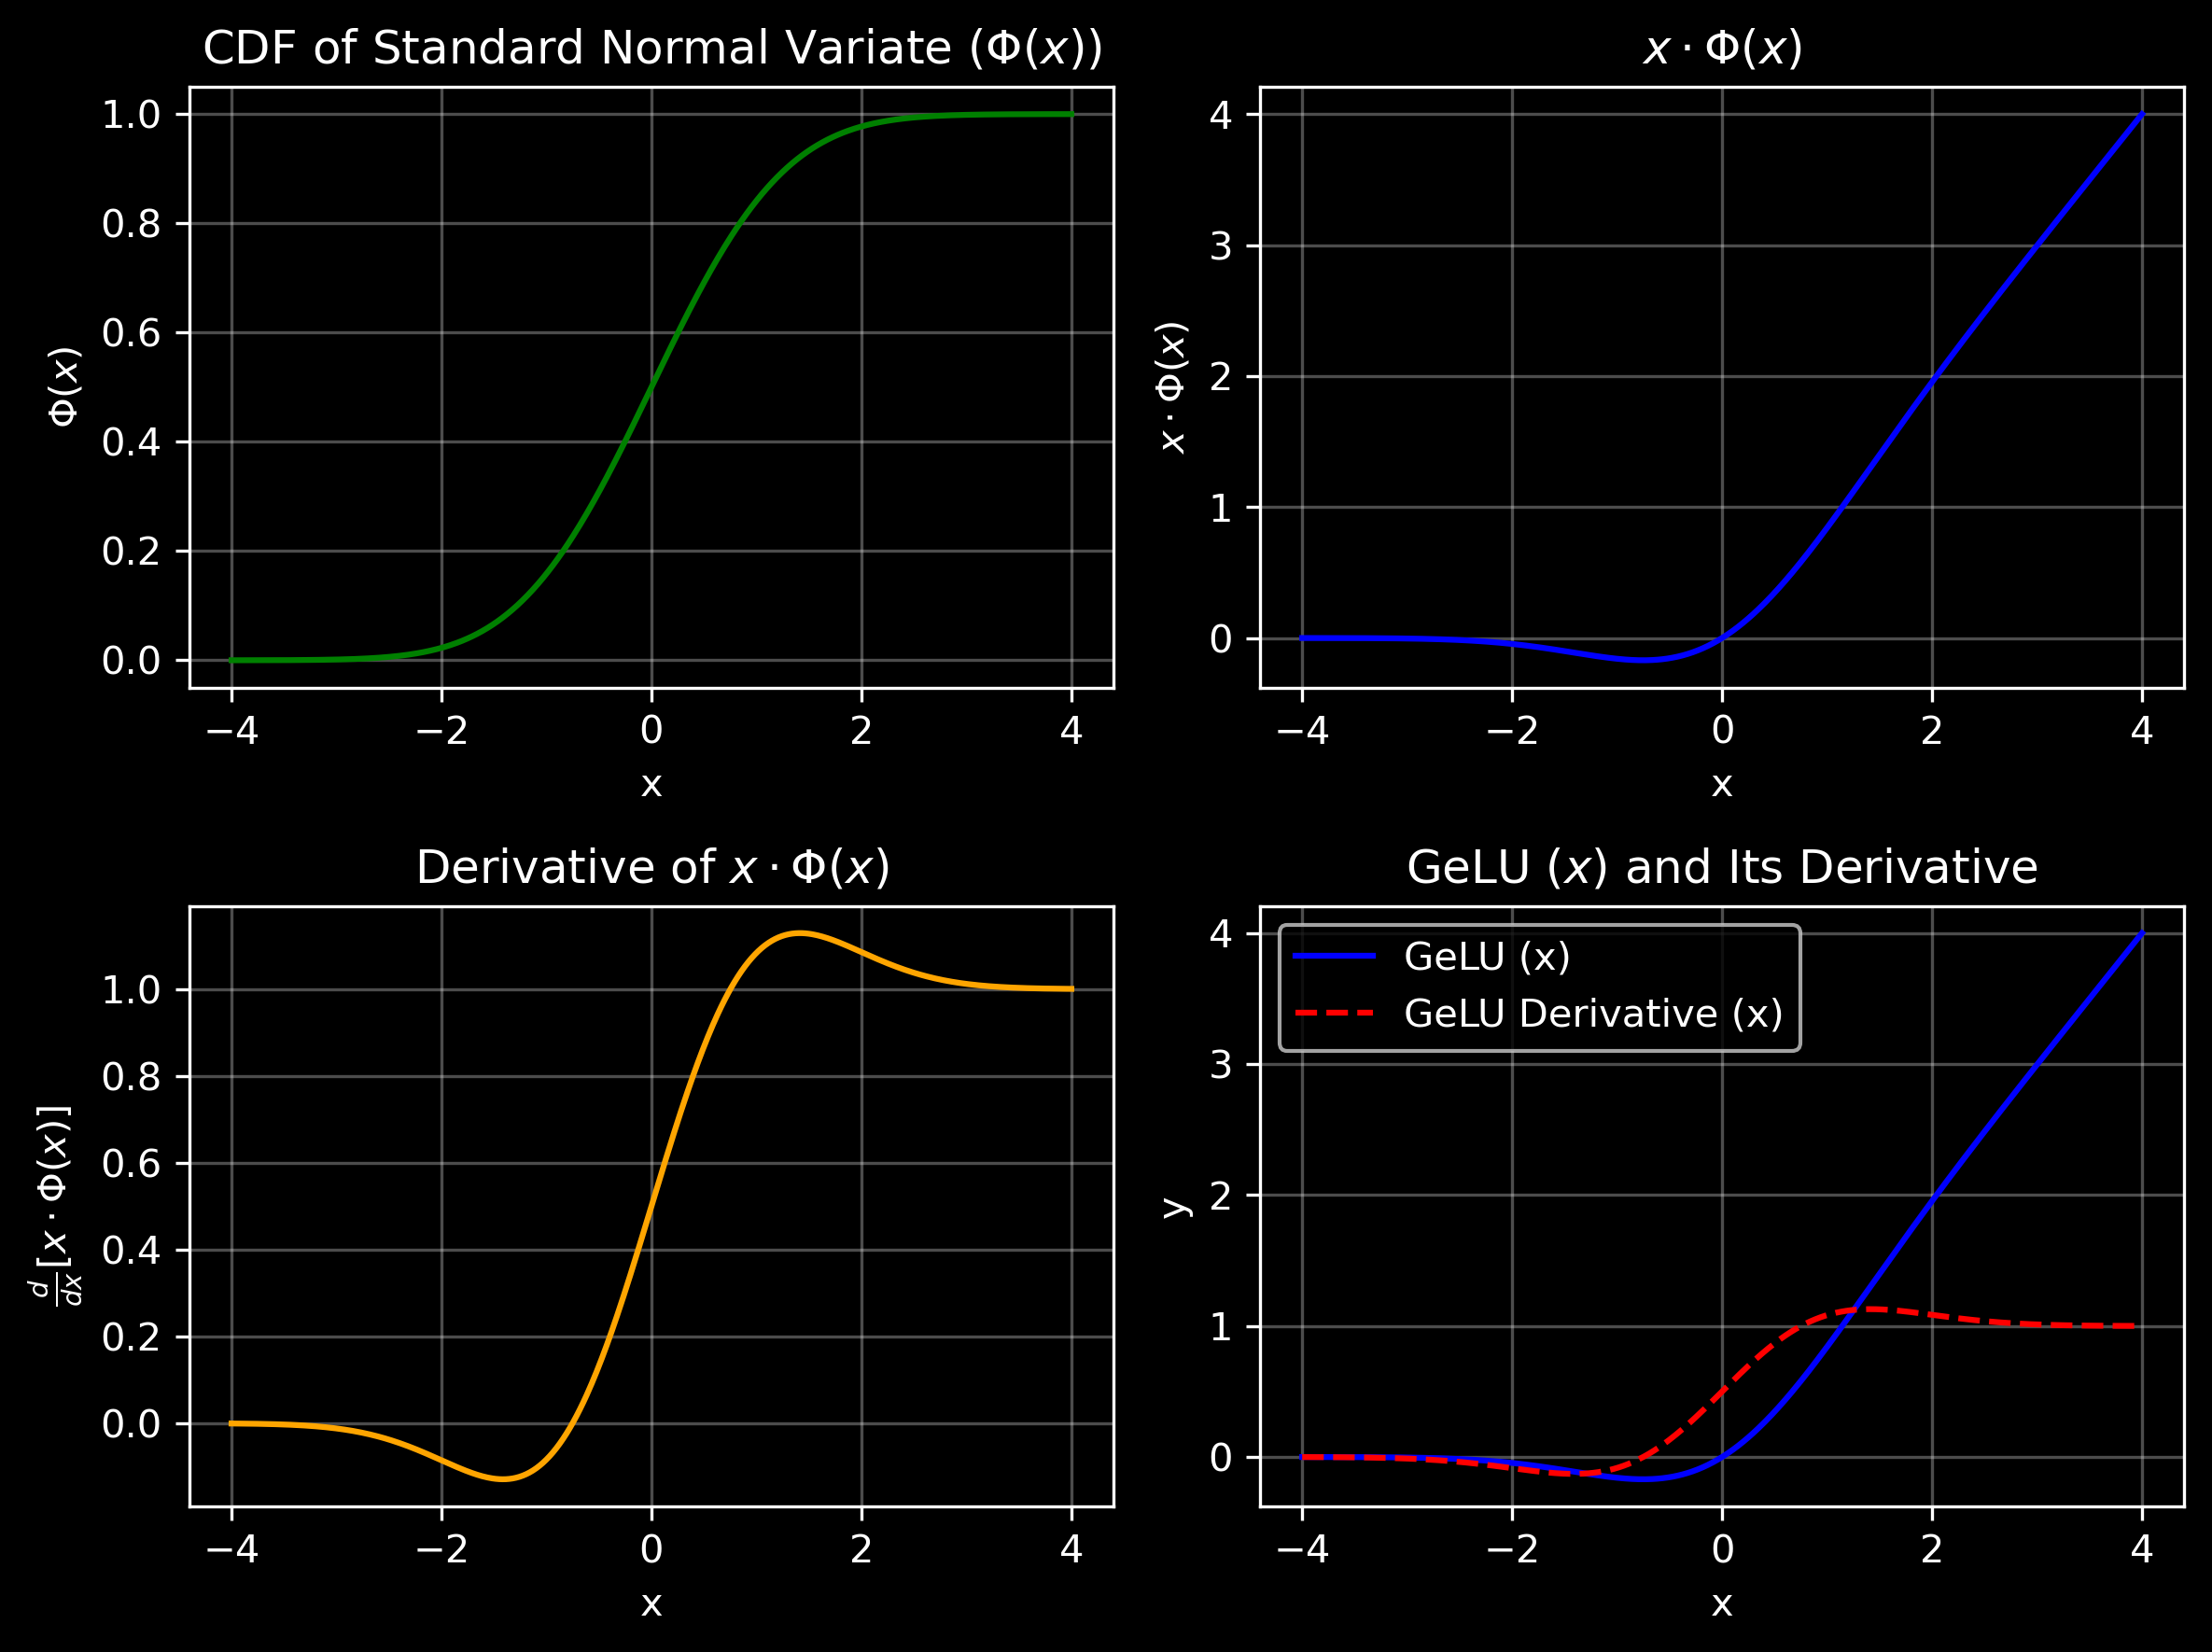

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

torch.manual_seed(47)
plt.style.use('dark_background')

# Define the range and standard normal CDF
x = torch.linspace(-4, 4, 500, requires_grad=True)
phi_x = 0.5 * (1 + torch.erf(x / torch.sqrt(torch.tensor(2.0))))  # CDF of x

# Compute GeLU using PyTorch's built-in function
x_input = torch.linspace(-4, 4, 500, requires_grad=True)
gelu_x = F.gelu(x_input)

# Compute the gradient (derivative) of GeLU
gelu_x.backward(torch.ones_like(x_input))
gelu_x_derivative = x_input.grad.clone()

# Compute x * Phi(x) and its derivative
x_cdf = x * phi_x
x_cdf.backward(torch.ones_like(x))
x_cdf_derivative = x.grad.clone()

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(8, 6), dpi=300)

# Plot 1: CDF of Standard Normal Variate (Phi(x))
axs[0, 0].plot(x.detach().numpy(), phi_x.detach().numpy(), color='green')
axs[0, 0].set_title(r"CDF of Standard Normal Variate ($\Phi(x)$)")
axs[0, 0].set_xlabel("x")
axs[0, 0].set_ylabel(r"$\Phi(x)$")
axs[0, 0].grid(alpha=0.3)

# Plot 2: x * Phi(x)
axs[0, 1].plot(x.detach().numpy(), x_cdf.detach().numpy(), color='blue')
axs[0, 1].set_title(r"$x \cdot \Phi(x)$")
axs[0, 1].set_xlabel("x")
axs[0, 1].set_ylabel(r"$x \cdot \Phi(x)$")
axs[0, 1].grid(alpha=0.3)

# Plot 3: Derivative of x * Phi(x)
axs[1, 0].plot(x.detach().numpy(), x_cdf_derivative.detach().numpy(), color='orange')
axs[1, 0].set_title(r"Derivative of $x \cdot \Phi(x)$")
axs[1, 0].set_xlabel("x")
axs[1, 0].set_ylabel(r"$\frac{d}{dx} \left[ x \cdot \Phi(x) \right]$")
axs[1, 0].grid(alpha=0.3)

# Plot 4: GeLU and Its Derivative (using x_input)
axs[1, 1].plot(x_input.detach().numpy(), gelu_x.detach().numpy(), label="GeLU (x)", color='blue')
axs[1, 1].plot(x_input.detach().numpy(), gelu_x_derivative.detach().numpy(), label="GeLU Derivative (x)", color='red', linestyle='--')
axs[1, 1].set_title(r"GeLU ($x$) and Its Derivative")
axs[1, 1].set_xlabel("x")
axs[1, 1].set_ylabel("y")
axs[1, 1].legend()
axs[1, 1].grid(alpha=0.3)

# Adjust layout
plt.tight_layout()
plt.show()